## Setup

A célula abaixo carrega as bibliotecas e arquivos necessários para gerar os dataframes e suas respectivas explorações neste .ipynb.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

online_pageviews = pd.read_json('dados/online_pageviews.json',lines='True')
offline_sales = pd.read_json('dados/offline_sales.json',lines='True')
online_orders = pd.read_json('dados/online_orders.json', lines='True')

## 1. Qual foi o faturamento total no período? 

Pode-se determinar o faturamento total do presente período fiscal como a soma do valor total de todos os pedidos online e físicos listados, sendo o valor total de um pedido determinado por `total_order_value = quantity X price`.

Assim, criando uma coluna adicional em cada dataframe de vendas, pode-se obter a soma do valor final de todas elas, online e físicas, conforme a céulula abaixo.

In [3]:
# gerar colunas de valor total de pedido para vendas físicas e online
offline_sales['total_order_value'] = offline_sales.apply(lambda row: (row['quantity'] * row['price']), axis=1)
online_orders['total_order_value'] = online_orders.apply(lambda row: (row['quantity'] * row['price']), axis=1)

# obter valor total de faturamento
total_value_from_sales_sum = offline_sales.total_order_value.sum() + online_orders.total_order_value.sum()
total_value_from_sales_sum


19552328.32

## 2. Qual foi o produto mais vendido online?

Para tanto, a forma mais direta é obter quais quantidades de produto estão associadas a determinado id de produto em cada pedido, somando-as e comparando de acordo. 

Buscando no dataframe 'online_orders', pode-se utilizar o método 'groupby' do pandas para agrupar todos os ids de produto e suas respectivas quantidades, que, conjuntamente com o método 'apply' e argumento 'sum', soma todos os valores encontrados de quantidade em função do id associado, retornando em formato de lista.

In [4]:
# agrupar por id e somar quantidades, ordenar por mais vendidos:
most_sold = online_orders.groupby('on_product_id')['quantity'].apply(sum).reset_index(drop=False)
most_sold.sort_values(by='quantity',ascending=False)

# caso queira apenas o resultado direto:
# most_sold.iloc[most_sold['quantity'].idxmax()]

,on_product_id,quantity
1670,626664333563363,74
1090,376531636530353,51
2021,656136316465643,50
1367,396464373131666,47
559,343033316438393,45
...,...,...
1616,623966383537613,1
563,343135343632306,1
995,373263393931653,1
994,373262643664646,1


Podemos ver então que o produto de id `626664333563363` é o mais vendido do período.

## 3. Cariocas gostam de comprar fim de semana?

"Gostam" é um critério muito subjetivo e **muito** dependente de contexto. Idealmente, 'gostar' envolve satisfação e prazer. No entanto, com os dados presentes, podemos fazer uma inferência de 'preferir', comparando o volume de vendas entre os dias de semana e o final de semana. 

Como o dataframe de entrada só possui datas em valor numérico no formato `date`, é melhor criar uma nova coluna que a partir desta data, nos dá o dia da semana, o que torna a comparação entre as vendas de sábado e domingo com as de segunda a sexta muito mais fáceis.

In [5]:
# gerar coluna de dias da semana de acordo com a data numérica fornecida
offline_sales['day_of_the_week'] = offline_sales['date'].dt.day_name()

# localizar todas as vendas do RJ
RJ_sales = offline_sales.loc[(offline_sales['state'] == 'RJ')]

Este tipo de questionamento conduz muito naturalmente a algum tipo de visualização. Como queremos saber a questão de preferência por volume de vendas, vamos comparar por dia da semana. No entanto, algumas necessidades específicas das ferramentas requerem certa manipulação.

Primeiro, para organizar o gráfico, devemos gerar uma série categórica que nos dá a ordem da semana (para os fins daqui, segunda a domingo). Depois, agrupamos a soma de todos os valores de venda de cada pedido em função do dia da semana, mostrados em barras.

(*NOTA TÉCNICA: importante notar que, ao gerar o gráfico via célula abaixo, o Pandas retorna um aviso. Isto ocorre devido a uma peculiaridade da linguagem Python e sua flexibilidade interpretativa, que para o Pandas, gera problemas por não saber se as engrenagens do Python estão retornando uma cópia ou uma 'view' (representação) do que foi atribuído. Como não serão feitas manipulações subsequentes dali, pode-se obter a visualização sem problemas.*)

C:\Users\main\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


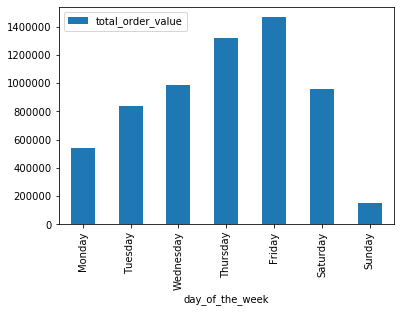

In [6]:
# ordenar a semana em formato categórico para ter uma ordem de visualização
RJ_sales['day_of_the_week'] = pd.Categorical(RJ_sales['day_of_the_week'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

# gerar gráfico de vendas físicas do RJ
RJ_sales_bar_plot = RJ_sales.groupby('day_of_the_week')['total_order_value'].apply(sum).reset_index(drop=False).plot(x='day_of_the_week',y='total_order_value', kind='bar')

Comparativamente falando, por meio do critério de volume de venda, cariocas têm preferência em comprar de segunda à sexta, no que diz respeito às lojas físicas.

## 4 - *É comum escolher online e terminar a compra na loja física?*

Primeiro, é necessário estabelecer o que é possível de analisar com os dados em mãos em relação aos fatores pedidos.

Uma possível (e talvez mais direta abordagem) é, sabendo que temos um campo `customer_id` comum às vendas físicas e aos pageviews, encontrar esta população e comparar aos demais clientes. Assumindo que os ids são correspondentes e se tratam de fato do mesmo cliente, teríamos então o grupo de consumidores registrados na loja online - e logados, importante lembrar - que fizeram compras físicas. Entretanto, isso não nos dá ideia de outro grupo muito possivelmente mais significativo, o dos visitantes que compram presencialmente.

Valores únicos de customer_id em offline_sales = 9901

Valores nulos para customer_id em offline_sales = 3528

Valores únicos de customer_id em online_pageviews = 5913

Valores nulos de customer_id em online_pageviews = **3371775**

Interseção de valores válidos entre os dois = 592

Se considerarmos nossa população de teste somente os clientes cadastrados, então temos apenas 6% deste grupo como pessoas que finalizam suas compras em loja física após visualizar online.



In [0]:
# contagem de ids
offline_sales['customer_id'].value_counts()
online_pageviews['customer_id'].value_counts()

# conjuntos válidos
s1 = offline_sales['customer_id'].dropna()
s2 = online_pageviews['customer_id'].dropna()

# contar valores nulos
count_nan = len(online_pageviews['customer_id']) - online_pageviews['customer_id'].count()
# count_nan

# obter interseção dos conjuntos
pd.Series(list(set(s1)&set(s2)))

## *5: O time de marketing desta rede quer fazer uma campanha oferecendo um cupom de 20% nas compras de loja física para quem visitou o site e abandonou um carrinho com produtos. Estime o resultado dessa campanha.*

É tentador modelar uma regressão logo de início, mas, talvez, temos já o suficiente para uma extrapolação interessante considerando os fatores da pergunta.

1 -- Visualização online para compra física. Como observado na questão #4, é possível inferir que comparado ao restante dos clientes, a população que vê o site para comprar na loja é bem pequena. Embora tenha sido feito somente a partir dos clientes cadastrados, ainda assim é uma amostragem significativa. A porcentagem da interseção entre clientes cadastrados e visualizações pode ser extrapolada aos demais?

2 -- Abandono de carrinho. Como isso poderia ser deduzido? Existem questões aqui que ultrapassam o escopo dos dados fornecidos. O site permite que um visitante não-cadastrado construa um carrinho? Se sim, é necessário criar um id de cliente para checkout? O checkout é tratado como uma compra online ou só no ato da retirada, em que vira uma compra física?

Assumindo um método semelhante à questão acima, ao localizarmos os clientes que possuem id e que visualizaram páginas de carrinho, temos 1476 de entradas de id único, de 5913 possíveis em `online_pageviews`. Entretanto, não temos como saber se os carrinhos tinham algo ou não. E/ou se houve abandono da compra,a partir disso.

Inferindo a partir das observações da #4, seria uma parcela muito pequena da clientela total, e menor ainda presumindo ainda estas condições adicionais sendo satisfeitas, para ser uma campanha de efeito significativo. Mais interessante seria talvez um cupom de desconto menor para primeira compra de visitantes online, permitindo aumentar inclusive a base de dados para análise?

In [16]:
pageviews_customers_with_carts = online_pageviews.loc[(online_pageviews['pageType'] == 'cart') & (online_pageviews['customer_id'])]
pageviews_customers_with_carts.drop_duplicates()

online_pageviews['customer_id'].dropna().drop_duplicates()

105        3.334316e+19
234        3.235393e+19
268        3.765363e+19
282        3.165624e+19
353        3.635314e+19
               ...     
3443224    3.330306e+19
3443895    3.766394e+19
3447089    6.438627e+19
3447523    3.330396e+19
3449241    3.430643e+19
Name: customer_id, Length: 5913, dtype: float64

# Outros dados:

## Volume de venda por estado: 

RJ e SP se posicionam consideravelmente à frente dos demais. Considerando que o Sudeste é região mais rica do país, segue uma tendência natural. Interessante, no entanto, se mantivermos a análise por questão de PIB, é notar a vantagem de Pernambuco sobre o Paraná - 10a e 5a economias do país, respectivamente.

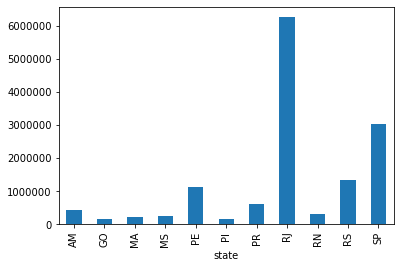

In [12]:
# obter volume de vendas por estado, gerar gráfico de barras:
total_sale_value_by_state = offline_sales.groupby('state')['total_order_value'].apply(sum)
total_sale_value_by_state.plot(x='state',y='total_order_value',kind='bar')

## Quantidade de visualizações de página por tipo de dispositivo:

Mantendo a par com a tendência global, compras em mobile são mais frequentes que em desktop.

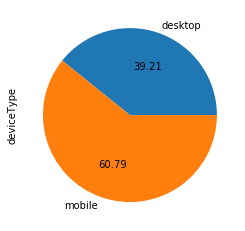

In [13]:
online_pageviews.groupby('deviceType')['deviceType'].count().plot.pie(autopct='%.2f')

## Descrição estatística dos pedidos online por cliente:

De 3530 clientes, temos um gasto médio de $1056.82, um desvio-padrão de 1484.56, com ganhos galopantes de dispêndio no último quartil: 1232.50 a 25703.00! Do primeiro ao terceiro, temos de 29.00 a 646.00.

In [37]:
online_orders.groupby('customer_id')['total_order_value'].sum().sort_values(ascending=False).describe()

count     3530.000000
mean      1056.820113
std       1484.565307
min         29.000000
25%        369.000000
50%        646.000000
75%       1232.500000
max      25703.000000
Name: total_order_value, dtype: float64

## Descrição estatística dos pedidos em loja física por cliente:

De 9901 clientes, temos um gasto médio superior ao online: 1246.50, mas um desvio-padrão muito mais acentuado (mais que o dobro, aliás). Os avanços nos quartis se demonstram razovalmente paralelos até, novamente, chegar no último: de 1156.00 a **106473.00**, uma diferença homérica na participação de gasto.

In [32]:
offline_sales.groupby('customer_id')['total_order_value'].sum().sort_values(ascending=False).describe()

count      9901.000000
mean       1246.500552
std        3105.569116
min           0.010000
25%         259.000000
50%         527.000000
75%        1156.000000
max      106473.000000
Name: total_order_value, dtype: float64

## *Bônus. O que mais de interessante tem nestes dados?*

Certamente, para um varejista (conforme a descrição do teste), é a participação maciça no valor total de vendas vinda de poucos clientes. Sem outras informações à mão, trata-se de uma interessante e representativa característica que corrobora o perfil de consumo nacional: certa homogeneidade consistente até determinado nível de gasto para avanços mais dramáticos conforme os percentis avançam ao topo.